In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Functions

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import pylab as pl,tensorflow as tf
from sklearn import datasets
import sklearn.model_selection as sms
from tensorflow.data import Dataset as tds

In [3]:
def pd_style():
    return [dict(selector='th',
                 props=[('font-size','10pt'),('min-width','45px')]),
            dict(selector='td',
                 props=[('padding','0em 0em'),('min-width','45px')]),
            dict(selector='tr:hover th:hover',
                 props=[('font-size','11pt'),('max-width','45px'),
                        ('text-shadow','3px 3px 3px #aaa')]),
            dict(selector='tr:hover td:hover',
                 props=[('font-size','10pt'),('max-width','45px'),
                        ('text-shadow','3px 3px 3px #aaa')])]

In [4]:
%radial_gradient_header Data Exploration

In [5]:
boston_data=datasets.load_boston()
columns=boston_data.feature_names
boston_df=pd.DataFrame(boston_data.data,columns=columns)
boston_df['MEDV']=boston_data.target
boston_df[['CHAS','RAD']]=boston_df[['CHAS','RAD']].astype('int64')
numeric_features=\
boston_df.columns[[0,2,4,5,6,7,9,10,11,12,13]]
stats=boston_df.describe().transpose()
dfn=boston_df.copy()
for nc in numeric_features:
    mean=stats.loc[nc,'mean']; std=stats.loc[nc,'std']
    dfn.loc[:,nc]=(dfn.loc[:,nc]-mean)/std
dfn[numeric_features].tail(int(10)).style.bar(
    align='mid',color=['#55eeee','#ee55ee'],
    subset=numeric_features).set_precision(3)\
   .set_table_styles(pd_style())

,CRIM,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
496,-0.386,-0.211,0.262,-1.273,0.154,-0.473,-0.102,0.344,0.441,1.188,-0.308
497,-0.389,-0.211,0.262,-0.698,0.072,-0.429,-0.102,0.344,0.441,0.203,-0.460
498,-0.392,-0.211,0.262,-0.378,-0.116,-0.658,-0.102,0.344,0.441,0.037,-0.145
499,-0.399,-0.211,0.262,-1.019,0.175,-0.663,-0.102,0.344,0.428,0.343,-0.547
500,-0.394,-0.211,0.262,-0.367,0.395,-0.616,-0.102,0.344,0.441,0.235,-0.623
501,-0.413,0.116,0.158,0.439,0.019,-0.625,-0.802,1.175,0.387,-0.418,-0.014
502,-0.415,0.116,0.158,-0.234,0.289,-0.716,-0.802,1.175,0.441,-0.500,-0.210
503,-0.413,0.116,0.158,0.984,0.797,-0.773,-0.802,1.175,0.441,-0.982,0.149
504,-0.407,0.116,0.158,0.725,0.736,-0.668,-0.802,1.175,0.403,-0.864,-0.058
505,-0.415,0.116,0.158,-0.362,0.434,-0.613,-0.802,1.175,0.441,-0.668,-1.156


In [6]:
%radial_gradient_header Data Processing

In [7]:
tfnumeric_features=[]
for nc in numeric_features[:-1]:
    tfnumeric_features.append(
        tf.feature_column.numeric_column(key=nc)) 
for nf in tfnumeric_features: 
    print(str(nf)); break
fchas=tf.feature_column\
.categorical_column_with_vocabulary_list(
    key='CHAS',vocabulary_list=[0,1])
frad=tf.feature_column\
.categorical_column_with_vocabulary_list(
    key='RAD',vocabulary_list=[1,2,3,4,5,6,7,8,24])
tfcategorical_features=[]
fchas_emb=tf.feature_column.embedding_column(fchas,dimension=2)
tfcategorical_features.append(fchas_emb)
frad_emb=tf.feature_column.embedding_column(frad,dimension=9)
tfcategorical_features.append(frad_emb)
print(str(tfcategorical_features[0]))
fzn=tf.feature_column.numeric_column(key='ZN')
tfbucketized_features=[tf.feature_column.bucketized_column(
    source_column=fzn,boundaries=[30,70,100])]
print(str(tfbucketized_features[0]))

NumericColumn(key='CRIM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='CHAS', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fe04d603850>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
BucketizedColumn(source_column=NumericColumn(key='ZN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(30, 70, 100))


In [8]:
features=(tfnumeric_features+tfbucketized_features+tfcategorical_features)
dfn_train,dfn_test=sms.train_test_split(dfn,train_size=.8,shuffle=True)
print(str([len(dfn_train),len(dfn_test)]))

[404, 102]


In [9]:
batch_size=8
def train_input_fn(dfn_train,batch_size):
    dft=dfn_train.copy()
    x_train,y_train=dft,dft.pop('MEDV')
    ds_train=tds.from_tensor_slices((dict(x_train),y_train))
    return ds_train.shuffle(len(x_train)).repeat().batch(batch_size)
ds_train=train_input_fn(dfn_train,batch_size)
batch=next(iter(ds_train))
print('keys: \n%s'%batch[0].keys())
print('batch values of `ZN`: \n %s'%batch[0]['ZN'])

keys: 
dict_keys(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
batch values of `ZN`: 
 tf.Tensor([ 0.  0.  0.  0.  0. 21.  0. 95.], shape=(8,), dtype=float64)


In [10]:
def test_input_fn(dfn_test,batch_size):
    dft2=dfn_test.copy()
    x_test,y_test=dft2,dft2.pop('MEDV')
    ds_test=tds.from_tensor_slices((dict(x_test),y_test))
    return ds_test.batch(batch_size)
ds_test=test_input_fn(dfn_test,batch_size)
batch=next(iter(ds_test))
print('keys: \n%s'%batch[0].keys())
print('batch values of `CHAS`: \n%s'%batch[0]['CHAS'])

keys: 
dict_keys(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
batch values of `CHAS`: 
tf.Tensor([0 0 1 0 0 0 0 0], shape=(8,), dtype=int64)


In [11]:
%radial_gradient_header Model Training

In [12]:
reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[104,52],
    model_dir='models/boston-dnnregressor/');

In [13]:
epochs=1000
steps=epochs*int(np.ceil(len(dfn_train)/batch_size))
print('training steps: %d'%steps)
reg.train(input_fn=lambda:train_input_fn(dfn_train,batch_size),steps=steps);

training steps: 51000


In [14]:
%radial_gradient_header Model Evaluation

In [15]:
reloaded_reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[104,52],
    warm_start_from='models/boston-dnnregressor/',
    model_dir='models/boston-dnnregressor/');

In [16]:
test_results=reloaded_reg.evaluate(
    input_fn=lambda:test_input_fn(dfn_test,batch_size))
for key in test_results:
    print('{}: {}'.format(key,test_results[key]))
print('test average loss% {:.4f}'\
      .format(test_results['average_loss']))

average_loss: 0.11035904288291931
label/mean: 0.06284347176551819
loss: 0.11002970486879349
prediction/mean: 0.10504470020532608
global_step: 51000
test average loss% 0.1104


In [17]:
y_test_pred=reg.predict(
    input_fn=lambda:test_input_fn(dfn_test,batch_size))
py_test=[]
for i in range(len(dfn_test)):
    py_test.append(next(iter(y_test_pred))['predictions'][0])

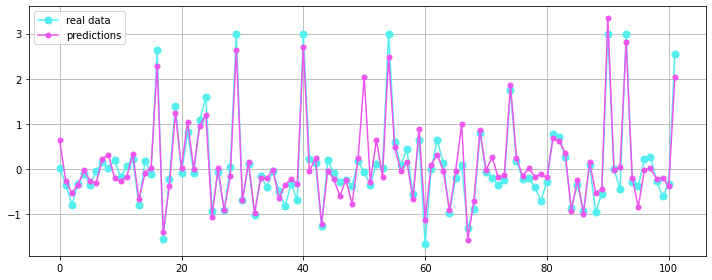

In [18]:
pl.figure(figsize=(10,4))
pl.plot(range(len(dfn_test)),dfn_test['MEDV'],
        '-o',label='real data',c='#55eeee',ms=7)
pl.plot(range(len(dfn_test)),py_test,
        '-o',label='predictions',c='#ee55ee',ms=5)
pl.tight_layout(); pl.grid(); pl.legend();